# Comparison between LLM and human games on 2007

In [39]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import itertools

In [40]:
players2007 = pd.read_csv('data/wikispeedia_paths-and-graph/paths_finished.tsv', sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
players2007['path'] = players2007.path.str.split(';')

In [41]:
players2007['start'] = players2007.path.str[0]
players2007['end'] = players2007.path.str[-1]

players2007 = players2007.groupby(['start', 'end']).apply(lambda x: x)
players2007 = players2007.drop(columns=['start', 'end'])

players2007['counts'] = players2007.groupby(by=['start', 'end']).size().sort_values(ascending=False)
players2007_filtered = players2007.loc[players2007.counts>=10]

players2007_filtered['length'] = players2007_filtered.path.map(len)
players2007_filtered


/tmp/ipykernel_3968/3738764707.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players2007_filtered['length'] = players2007_filtered.path.map(len)


hashedIpAddress   timestamp  durationInSec  \
start        end                                                          
14th_century Rainbow 7      20418ff4797f96be  1229188046            139   
                     8      08888b1b428dd90e  1232241510             74   
                     9      08888b1b428dd90e  1232241601            167   
                     10     4cb0068c36658716  1248654953            253   
                     11     1082b6b8501a04b1  1248791776            218   
...                                      ...         ...            ...   
Weed         Jesus   20038  0bf7d1911edce329  1309954527             94   
                     20039  450a79941c0d7d43  1326529979             46   
                     20040  4d101f19793920f5  1334342796             68   
                     20041  4d101f19793920f5  1334342912             69   
                     20042  4d101f19793920f5  1334342972             35   

                                                                         path  \
start        end                                                                
14th_century Rainbow 7      [14th_century, Time, Isaac_Newton, Light, Colo...   
                     8                   [14th_century, Time, Light, Rainbow]   
                     9      [14th_century, 15th_century, Plato, Nature, Ul...   
                     10     [14th_century, Time, Science, Nature, Weather,...   
                     11     [14th_century, Christianity, Bible, God, Natur...   
...                                                                       ...   
Weed         Jesus   20038  [Weed, Greenhouse_effect, Global_warming, Sola...   
                     20039  [Weed, Sumac, Fruit, Animal, Human, Religion, ...   
                     20040  [Weed, Dandelion, Australia, United_Kingdom, <...   
                     20041  [Weed, Dandelion, British_Isles, Ireland, Roma...   
                     20042  [Weed, Dandelion, British_Isles, Ireland, Roma...   

                            rating  counts  length  
start        end                                    
14th_century Rainbow 7         1.0      27       6  
                     8         3.0      27       4  
                     9         NaN      27       7  
                     10        3.0      27      13  
                     11        3.0      27      10  
...                            ...     ...     ...  
Weed         Jesus   20038     2.0      11       8  
                     20039     1.0      11       8  
                     20040     NaN      11       9  
                     20041     NaN      11       6  
                     20042     NaN      11       6  

[6927 rows x 7 columns]

In [42]:
players2007_filtered = players2007_filtered[players2007_filtered['length']<50]

In [43]:
def remove_consecutive_duplicates(x):
    """
    Remove identical consecutive elements in a list 

    Args:
    x (list): list to clean

    Returns:
    y (list): x without 2 identical consecutive elements
    """
    return [i[0] for i in itertools.groupby(x)]

def remove_periodic_loop(x):
    """
    Remove periodic loops

    Args:
    x (list): list to clean

    Returns:
    y (list): x without periodic loops
    """
    to_remove = []
    for j in range(1, len(x)-1):
        for i in range(len(x)-j):
            if x[i:i+j]==x[i+j:i+2*j]:
                for k in range(i, i+j):
                    to_remove.append(k)

    return [i for j, i in enumerate(x) if j not in to_remove]

def stop_when_found(x):
    """
    Cut the list to the first occurence of the target word.

    Args:
    x (list): list to clean

    Returns:
    y (list): x stopping at the first appearence of word
    """
    # print(list(x).index(x[-1]), len(x)-1)
    # print(x[-1])
    if list(x).index(x[-1])!=len(list(x))-1:
        return x[:list(x).index(x[-1])+1]
    else:
        return x


def solution_on_already_visited_page(x):
    """
    Cut the list after first occurence of the second to last page leading to the target.
    i.e. we assume a human player always click the target word if the word is present on a page visited.
    Pb.: maybe other visited pages lead to the target word and we don't know it.

    Args:
    x (list): list to clean

    Returns:
    y (list): x stopping at the first appearence of the last page leading to the target + target.
    """

    if list(x).index(x[-2])!=len(list(x))-2:
        return x[:list(x).index(x[-2])+1]+[x[-1]]
    else:
        return x


llm2007 = pd.read_csv('data/llm_paths.csv')
llm2007_filtered = llm2007.copy(deep=True)
llm2007_filtered = llm2007_filtered.dropna()
llm2007_filtered.path = llm2007_filtered.path.apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llm2007_filtered = llm2007_filtered.set_index(['start', 'end'])
llm2007_filtered.path = llm2007_filtered.path.apply(stop_when_found)
llm2007_filtered.path = llm2007_filtered.path.apply(solution_on_already_visited_page)
llm2007_filtered.path = llm2007_filtered.path.apply(remove_consecutive_duplicates)
llm2007_filtered.path = llm2007_filtered.path.apply(remove_periodic_loop)
llm2007_filtered['length']=llm2007_filtered.path.apply(len)

In [44]:
llm2007_filtered


,,path,length
start,end,,
Brain,Telephone,"[Brain, Computer_science, Information, Mass_me...",5
Theatre,Zebra,"[Theatre, Brazil, Rainforest, Mammal, Zebra]",5
Asteroid,Viking,"[Asteroid, Comet, Denmark, Viking]",4
Pyramid,Bean,"[Pyramid, Mexico, Agriculture, Pea, Vegetable,...",9
Batman,Wood,"[Batman, Scotland, Scottish_Highlands, Orkney,...",9
...,...,...,...
Barbados,Virus,"[Barbados, Climate, Ocean, Organism, Virus]",5
ASCII,Swastika,"[ASCII, Microsoft_Windows, Windows_2000, Hebre...",10
Necktie,Lion,"[Necktie, England, Lion]",3


In [45]:

avglen = pd.DataFrame(players2007_filtered.length.groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))#.apply(lambda x: x)
avglen = avglen.rename(columns={'length':'players2007'})
avglen = pd.merge(avglen, llm2007_filtered['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llm2007'})

In [46]:
avglen.tail(30)

mean  \
start                                       end                               
Mario                                       God                    6.636364   
                                            Nintendo               5.266667   
Mathematics                                 Juice                 10.900000   
Metal                                       Prague                 7.333333   
Meteorological_history_of_Hurricane_Katrina Iraq_War               4.727273   
Moon                                        Mars                   3.000000   
Mormon                                      Ice                    8.454545   
Necktie                                     Lion                   5.200000   
Nintendo                                    Snow                   5.857143   
North_America                               Canada                 2.076923   
Ocean                                       Love                  10.545455   
Pikachu                                     Jesus                  5.933333   
                                            Sun                    4.176471   
Planet                                      Nuclear_power          6.400000   
Pluto                                       Wall_Street            6.400000   
Pyramid                                     Adolf_Hitler           5.300000   
                                            Bean                   8.180967   
Reptile                                     Jesus                  5.466667   
Scent_of_a_Woman                            Firearm                6.363636   
Seed                                        New_York_City          4.909091   
Smog                                        Toy_Story              8.529412   
Solar_System                                Babe_Ruth              9.454545   
The_Godfather                               Neptune                6.384615   
Theatre                                     Zebra                  7.836464   
United_States                               English_language       3.142857   
Video                                       China                  6.500000   
Volcano                                     Alphabet               5.642857   
Wasp                                        United_Arab_Emirates   7.200000   
Weasel                                      Barium                 9.600000   
Weed                                        Jesus                  7.363636   

                                                                       std  \
start                                       end                              
Mario                                       God                   1.286291   
                                            Nintendo              8.672342   
Mathematics                                 Juice                 2.923088   
Metal                                       Prague                1.922751   
Meteorological_history_of_Hurricane_Katrina Iraq_War              1.618080   
Moon                                        Mars                  0.000000   
Mormon                                      Ice                   2.910795   
Necktie                                     Lion                  3.047768   
Nintendo                                    Snow                  1.833750   
North_America                               Canada                0.277350   
Ocean                                       Love                  6.758160   
Pikachu                                     Jesus                 1.334523   
                                            Sun                   0.528594   
Planet                                      Nuclear_power         2.412928   
Pluto                                       Wall_Street           3.565265   
Pyramid                                     Adolf_Hitler          1.636392   
                                            Bean                  3.930054   
Reptile                                     Jesus           

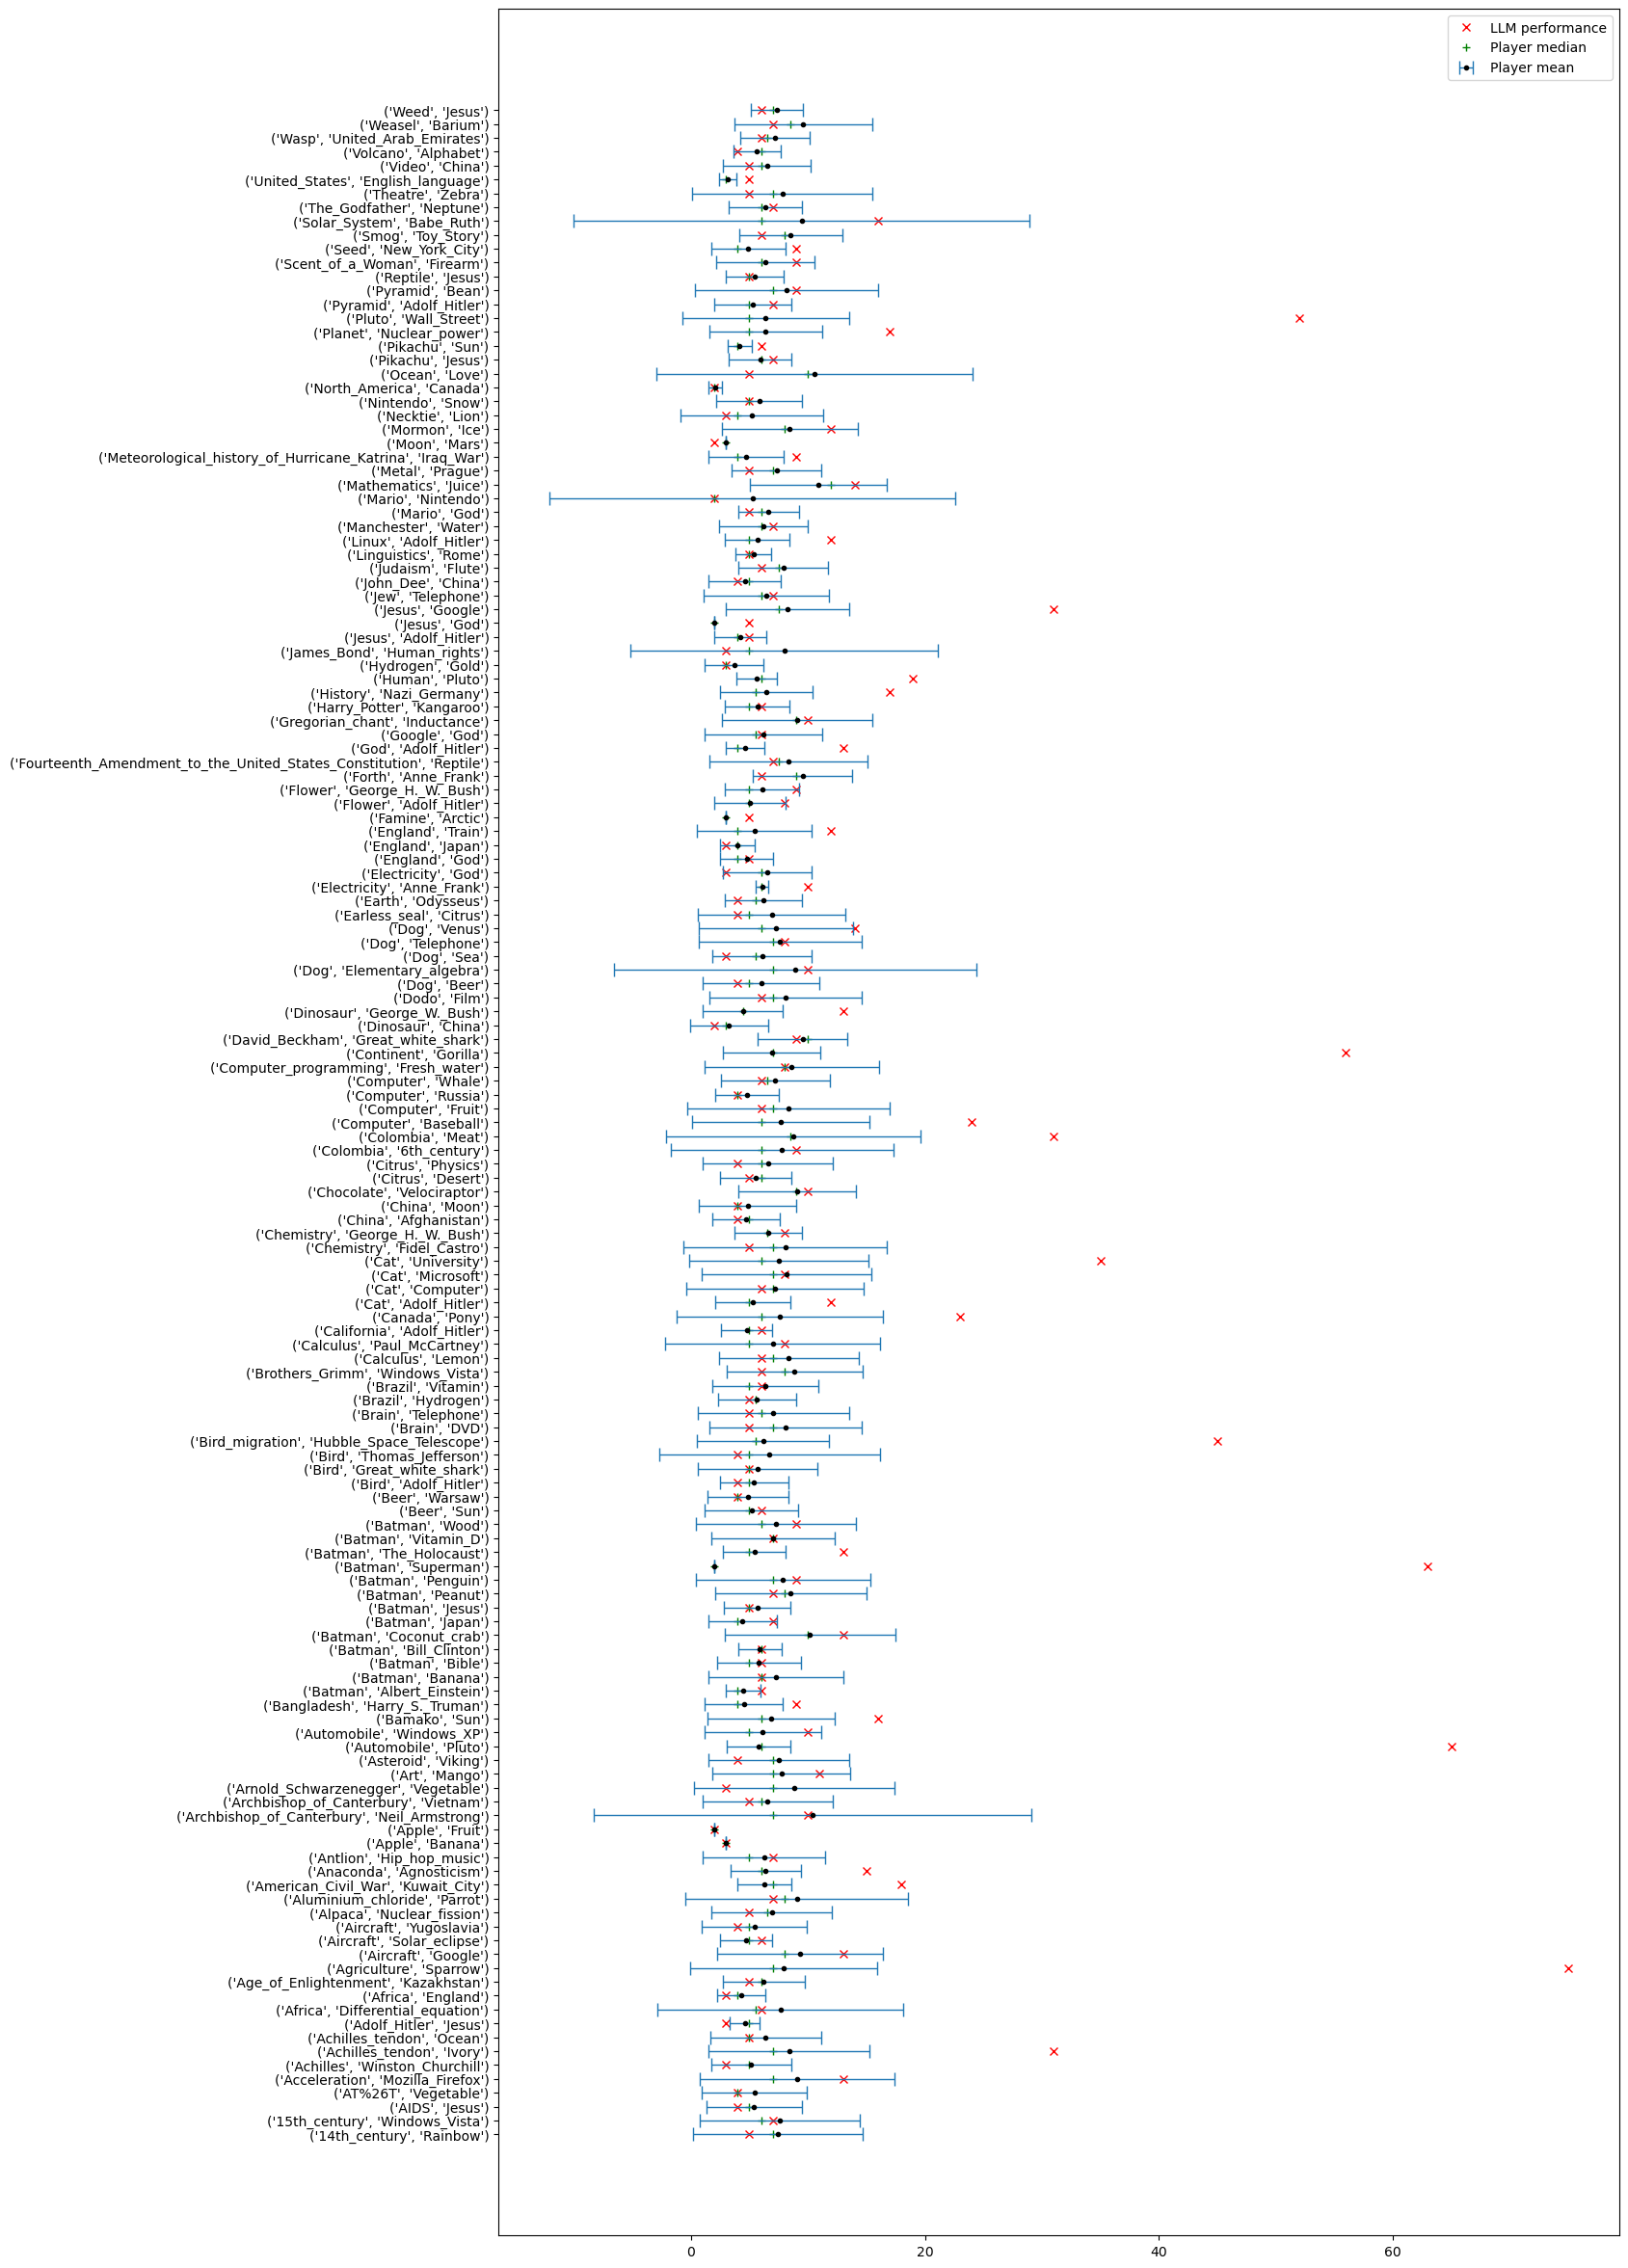

In [47]:
plt.figure(figsize=(15,30))
plt.plot(avglen['llm2007'], np.array(range(len(avglen['llm2007']))), 'rx', label='LLM performance')
plt.plot(avglen['median'], np.array(range(len(avglen['median']))), 'g+', label='Player median')
plt.errorbar(avglen['mean'], np.array(range(len(avglen['mean']))), xerr=2*avglen['std'], linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3, markerfacecolor = 'black', markeredgecolor = 'black', capsize= 5, label='Player mean')

plt.yticks(range(len(avglen.index)), avglen.index)
plt.legend();

In [48]:
def check_if_in_CI(x):
    return ((x['mean']-x['std'])<=x['llm2007']) and ((x['mean']+x['std'])>=x['llm2007'])

avglen['in_CI'] = avglen.apply(check_if_in_CI, axis=1)
print(f'Number of LLM games in CI from player games: {avglen.in_CI.mean()*100}%')

Number of LLM games in CI from player games: 57.82312925170068%


DEBUG:: [13  2 21], range(0, 29), [['Computer', 'Middle_Ages', 'Black_Death', 'Hunger', 'Famine', 'Seed', 'Fruit'], ['Computer', 'Middle_Ages', '<', 'Great_Britain', 'Climate', 'Global_warming', 'Agriculture', 'Fruit'], ['Computer', 'Toy', 'Apple', 'Fruit'], ['Computer', 'Great_Britain', 'Wales', 'Ice_age', 'Climate', 'Weather', 'Tropics', 'Rainforest', 'Mammal', '<', 'Reptile', 'Food', 'Vitamin_C', '<', 'Peanut', 'Fruit'], ['Computer', 'Unix', '<', 'Microsoft_Windows', 'Microsoft', 'Bill_Gates', '<', 'Corporation', '<', 'Bill_Gates', '<', '<', 'Macintosh', '<', '<', 'Telephone', 'New_York_City', 'Culture', 'Nature', 'Plant', 'Fruit'], ['Computer', 'Python_%28programming_language%29', 'Netherlands', 'Glacier', 'Fresh_water', 'Water_resources', 'Irrigation', 'Peru', 'El_Ni%C3%B1o-Southern_Oscillation', 'Famine', 'Agriculture', 'Food', 'Scurvy', 'Fruit'], ['Computer', 'History_of_computing_hardware', '<', 'Microsoft_Windows', 'Macintosh', 'ITunes', '<', '<', 'Macintosh', 'IPod', 'United_

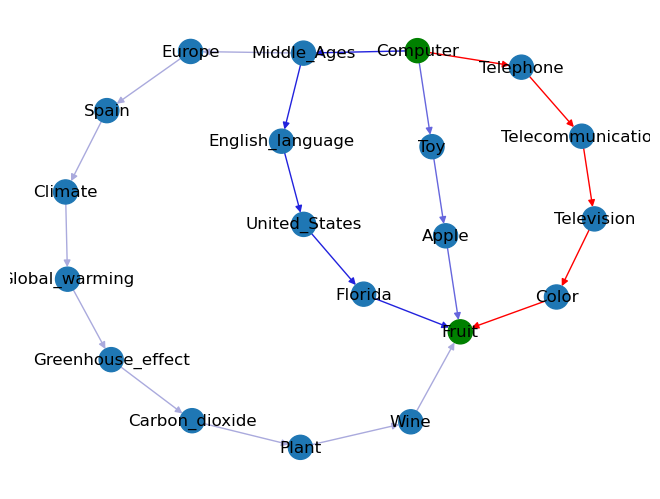

In [50]:
def compare_paths(start, end, n=1, df_LLM=llm2007_filtered, df_players=players2007_filtered):
    """
    Compare 2 paths by showing them on a graph

    Args:
    start (str): LLM path
    end (str): others path
    n (int: number of paths of players to draw
    df_LLM (pd.series): path of the LLM
    df_players (pd.series): paths of the players
    

    Returns:
    DiGraph: graph of the different paths
    """
    try:
        path1 = df_LLM.path.loc[start, end]
    except:
        print('No LLM game corresponding.')

    try:
        path2 = list(df_players.path.loc[start, end])
    except:
        print('No player game corresponding.')


    colors_paths = ['#aaaadd', '#6666dd', '#2222dd']
    indices = np.random.choice(range(len(path2)), n)
    print(f'DEBUG:: {indices}, {range(len(path2))}, {path2}')

    G = nx.DiGraph()
    G.add_nodes_from(path1[1:-1], color='tab:blue')
    G.add_nodes_from([start, end], color='g')
    
    for i in range(len(path1)-1):
        G.add_edge(path1[i], path1[i+1], color='r')
    for idx, k in zip(indices, range(n)):
        G.add_nodes_from(path2[idx][1:-1], color='tab:blue')
        for j in range(len(path2[idx])-1):
            G.add_edge(path2[idx][j], path2[idx][j+1], color=colors_paths[k%n])

    pos = nx.kamada_kawai_layout(G)
    edges_colors = nx.get_edge_attributes(G,'color').values()
    nodes_colors = nx.get_node_attributes(G,'color').values()

    nx.draw(G, pos, node_color=nodes_colors, edge_color=edges_colors, with_labels=True)
    return G

G = compare_paths('Computer', 'Fruit', 3)

# Compare with 2024

In [73]:


llm2024 = pd.read_csv('data/llm_paths2024.csv')
llm2024 = llm2024.dropna()
llm2024.path = llm2024.path.apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llm2024 = llm2024.set_index(['start', 'end'])
llm2024_filtered = llm2024.copy(deep=True)
llm2024_filtered.path = llm2024_filtered.path.apply(stop_when_found)
llm2024_filtered.path = llm2024_filtered.path.apply(solution_on_already_visited_page)
llm2024_filtered.path = llm2024_filtered.path.apply(remove_consecutive_duplicates)
llm2024_filtered.path = llm2024_filtered.path.apply(remove_periodic_loop)
llm2024_filtered.path = llm2024_filtered.path.apply(remove_consecutive_duplicates)
llm2024_filtered.path = llm2024_filtered.path.apply(remove_periodic_loop)
llm2024_filtered['length']=llm2024_filtered.path.apply(len)

In [74]:
llm2024_filtered.path.loc['15th_century', 'Windows_Vista']

['15th_century',
 '16th_century',
 '6th_century',
 '16th_century',
 'Brazil',
 'Akbar',
 'Spain',
 'Macau',
 'Spain',
 'Ethiopia',
 'Elizabeth_I_of_England',
 'Brazil',
 'Amazon_River',
 'Philip_II_of_Spain',
 'Ethiopia',
 'Japan',
 'Edward_VI_of_England',
 'Japan',
 'Timbuktu',
 'China',
 'Japan',
 'Brazil',
 'Akbar',
 'Istanbul',
 'England',
 'Libya',
 'Mary_I_of_England',
 'Brazil',
 'Elizabeth_I_of_England',
 'Tower_of_London',
 'Mary_I_of_England',
 'Akbar',
 'Philip_II_of_Spain',
 'Macau',
 'Ethiopia',
 'Elizabeth_I_of_England',
 'Akbar',
 'Japan',
 'London',
 'Akbar',
 'London',
 'Brazil',
 'Manila',
 'Spain',
 'Akbar',
 'Francis_Drake',
 'Belgium',
 'Francis_Drake',
 'Philip_II_of_Spain',
 'Akbar',
 'London',
 'Japan',
 'Turkey',
 'Akbar',
 'Philip_II_of_Spain',
 'Francis_Drake',
 'Philip_II_of_Spain',
 'Grand_Canyon',
 'Amazon_River',
 'Japan',
 'China',
 'England',
 'United_Kingdom',
 'India',
 'Canada',
 'Australia',
 'South_Africa',
 'Tanzania',
 'India',
 'Pakistan',
 'Aus

In [85]:
# merging data from 2024

avglen = pd.DataFrame(players2007_filtered.length.groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))#.apply(lambda x: x)
avglen = avglen.rename(columns={'length':'players2007'})
avglen = pd.merge(avglen, llm2007_filtered['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llm2007'})

avglen = pd.merge(avglen, llm2024_filtered['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llm2024'})

def check_if_in_CI(x, year):
    return ((x['mean']-x['std'])<=x[f'llm{year}']) and ((x['mean']+x['std'])>=x[f'llm{year}'])

avglen['in_CI_2007'] = avglen.apply(lambda x: check_if_in_CI(x, '2007'), axis=1)
avglen['in_CI_2024'] = avglen.apply(lambda x: check_if_in_CI(x, '2024'), axis=1)
print(f'Number of LLM games 2007 in CI from player games: {avglen.in_CI_2007.mean()*100}%')
print(f'Number of LLM games 2024 in CI from player games: {avglen.in_CI_2024.mean()*100}%')

avglen

Number of LLM games 2007 in CI from player games: 58.57142857142858%
Number of LLM games 2024 in CI from player games: 27.142857142857142%


,,mean,std,median,count,llm2007,llm2024,in_CI_2007,in_CI_2024
start,end,,,,,,,,
14th_century,Rainbow,7.444444,3.630356,7.0,27,5,24,True,False
15th_century,Windows_Vista,7.625000,3.422962,6.0,16,7,163,True,False
AIDS,Jesus,5.411765,2.032819,5.0,17,4,57,True,False
AT%26T,Vegetable,5.416667,2.234373,4.0,12,4,58,True,False
Acceleration,Mozilla_Firefox,9.090909,4.158234,7.0,11,13,20,True,False
...,...,...,...,...,...,...,...,...,...
Video,China,6.500000,1.886484,6.0,18,5,4,True,False
Volcano,Alphabet,5.642857,1.008208,6.0,14,4,4,False,False
Wasp,United_Arab_Emirates,7.200000,1.475730,6.5,10,6,88,True,False


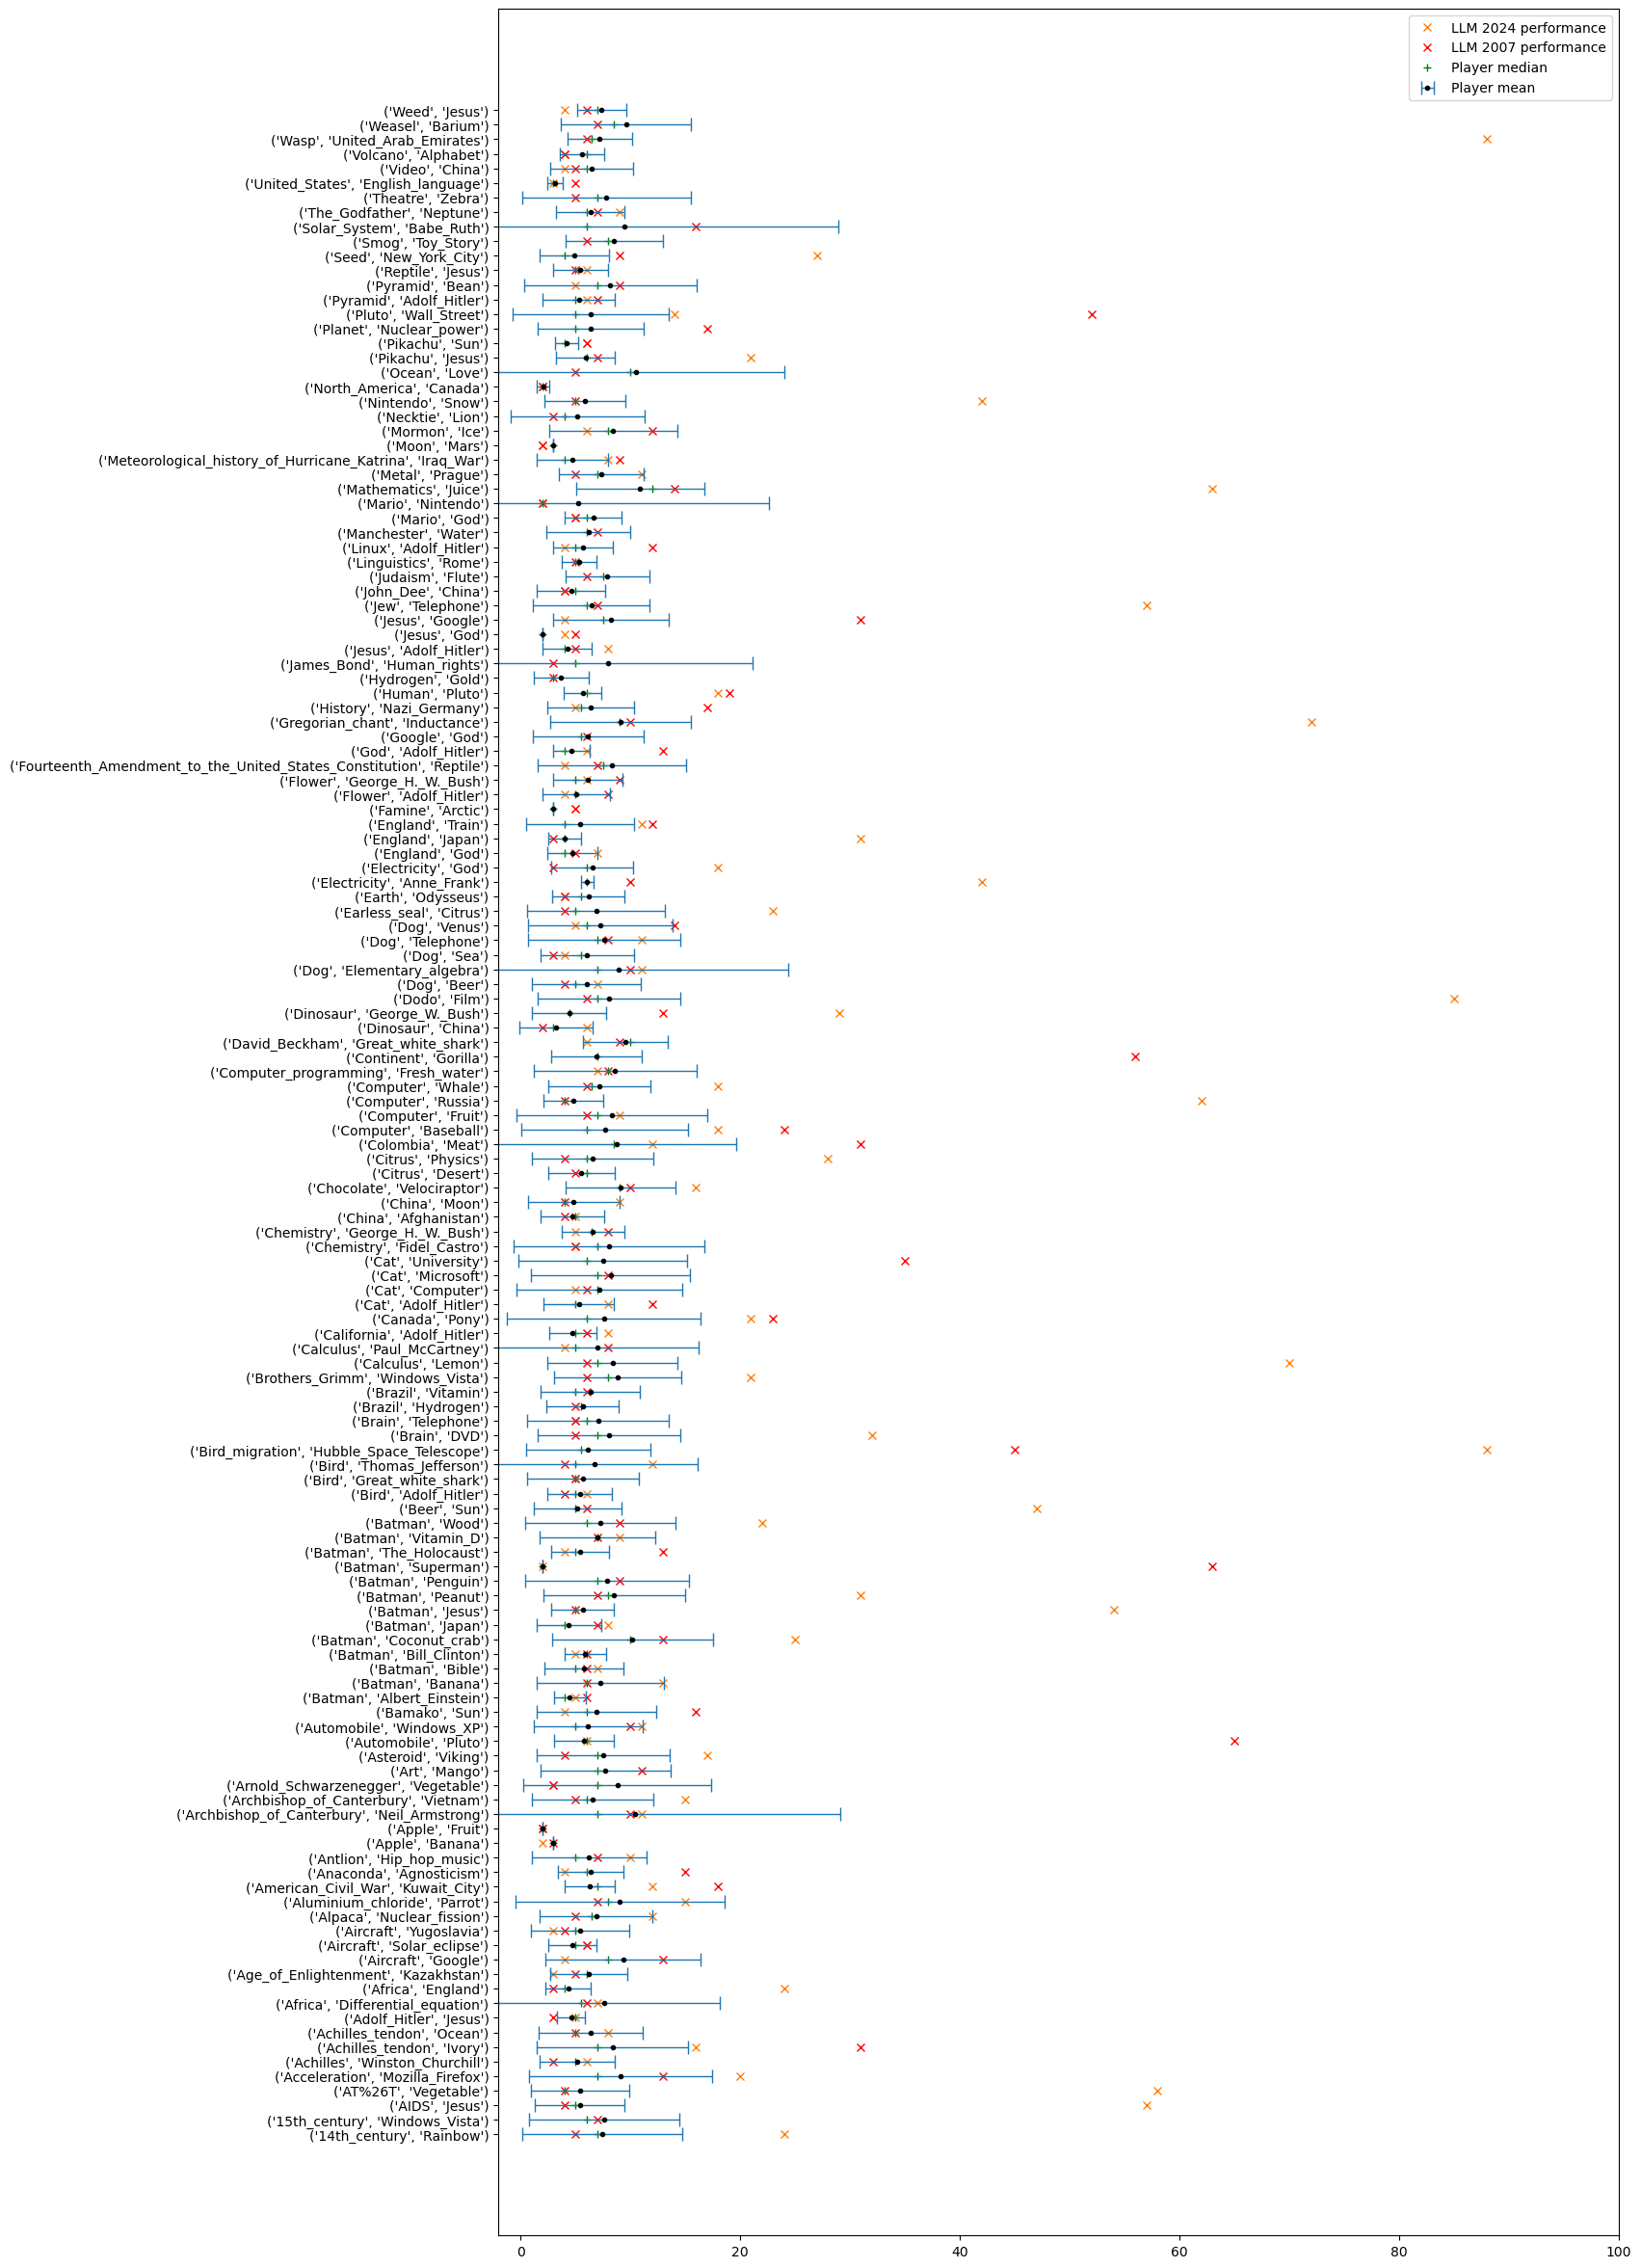

In [76]:
plt.figure(figsize=(15,30))
plt.plot(avglen['llm2024'], np.array(range(len(avglen['llm2024']))), 'x', color='tab:orange', label='LLM 2024 performance')
plt.plot(avglen['llm2007'], np.array(range(len(avglen['llm2007']))), 'rx', label='LLM 2007 performance')
plt.plot(avglen['median'], np.array(range(len(avglen['median']))), 'g+', label='Player median')
plt.errorbar(avglen['mean'], np.array(range(len(avglen['mean']))), xerr=2*avglen['std'], linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3, markerfacecolor = 'black', markeredgecolor = 'black', capsize= 5, label='Player mean')

plt.yticks(range(len(avglen.index)), avglen.index)
plt.xlim((-2, 100))
plt.legend();

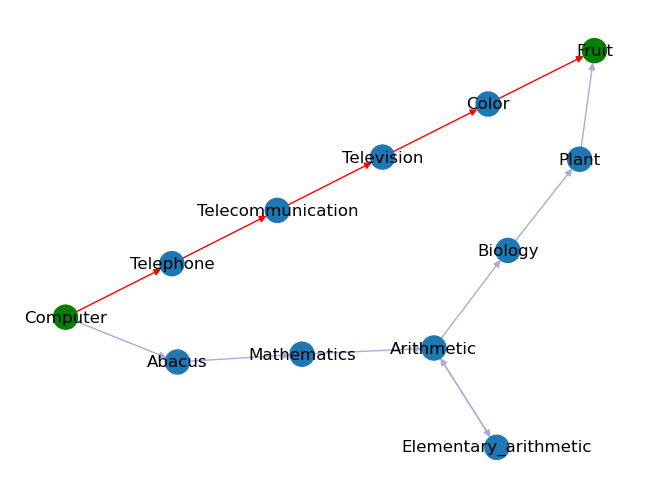

In [77]:
def compare_paths_LLMs(start, end, n=1, df_LLM=llm2007_filtered, df_players=llm2024_filtered):
    """
    Compare 2 paths by showing them on a graph

    Args:
    start (str): LLM path
    end (str): others path
    n (int: number of paths of players to draw
    df_LLM (pd.series): path of the LLM
    df_players (pd.series): paths of the players
    

    Returns:
    DiGraph: graph of the different paths
    """
    try:
        path1 = df_LLM.path.loc[start, end]
    except:
        print('No LLM game corresponding.')

    try:
        path2 = df_players.path.loc[start, end]
    except:
        print('No player game corresponding.')


    colors_paths = ['#aaaadd', '#6666dd', '#2222dd']

    G = nx.DiGraph()
    G.add_nodes_from(path1[1:-1], color='tab:blue')
    G.add_nodes_from([start, end], color='g')
    
    for i in range(len(path1)-1):
        G.add_edge(path1[i], path1[i+1], color='r')
    G.add_nodes_from(path2[1:-1], color='tab:blue')
    for j in range(len(path2)-1):
        G.add_edge(path2[j], path2[j+1], color=colors_paths[0])

    pos = nx.kamada_kawai_layout(G)
    edges_colors = nx.get_edge_attributes(G,'color').values()
    nodes_colors = nx.get_node_attributes(G,'color').values()

    nx.draw(G, pos, node_color=nodes_colors, edge_color=edges_colors, with_labels=True)
    return G

G = compare_paths_LLMs('Computer', 'Fruit', 1, llm2007_filtered, llm2024_filtered)

# Checking that all the stuff that could be filtered has been filtered

Weird format:
- same word repeated consecutively (e.g. Computer, Fruit): DONE
- remove useless loops repeated several times (e.g. '14th_century', 'Rainbow'): DONE
- doesn't stop after finding the word (e.g. Batman, Vitamin_D): DONE
- is on a page directly leading to the target but doesn't select the target (e.g. Batman, Vitamin_D): DONE



In [78]:
llm2024_filtered.path.loc['Computer', 'Fruit']

['Computer',
 'Abacus',
 'Mathematics',
 'Arithmetic',
 'Elementary_arithmetic',
 'Arithmetic',
 'Biology',
 'Plant',
 'Fruit']

In [79]:
llm2024_filtered.path.loc['Theatre', 'Zebra']

['Theatre',
 'Ancient_Rome',
 'Celery',
 'Celeriac',
 'Parsnip',
 'Carrot',
 'Celeriac',
 'Celery',
 'Wasabi',
 'Wikispecies',
 'Wikipedia',
 'Croatia',
 'Slovenia',
 'Hungary',
 'Serbia',
 'Bosnia_and_Herzegovina',
 'Montenegro',
 'Italy',
 'Austria',
 'Serbia',
 'Bosnia_and_Herzegovina',
 'Montenegro',
 'Slovenia',
 'Bosnia_and_Herzegovina',
 'Hungary',
 'Serbia',
 'Albania',
 'Armenia',
 'Austria',
 'Belarus',
 'Belgium',
 'Bosnia_and_Herzegovina',
 'Bulgaria',
 'France',
 'Greece',
 'Hungary',
 'Iceland',
 'Italy',
 'Kazakhstan',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Romania',
 'Russia',
 'Serbia',
 'Slovakia',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'Ukraine',
 'United_Kingdom',
 'Kosovo',
 'Albania',
 'Algeria',
 'Bosnia_and_Herzegovina',
 'Egypt',
 'France',
 'Greece',
 'Israel',
 'Italy',
 'Lebanon',
 'Malta',
 'Monaco',
 'Montenegro',
 'Morocco',


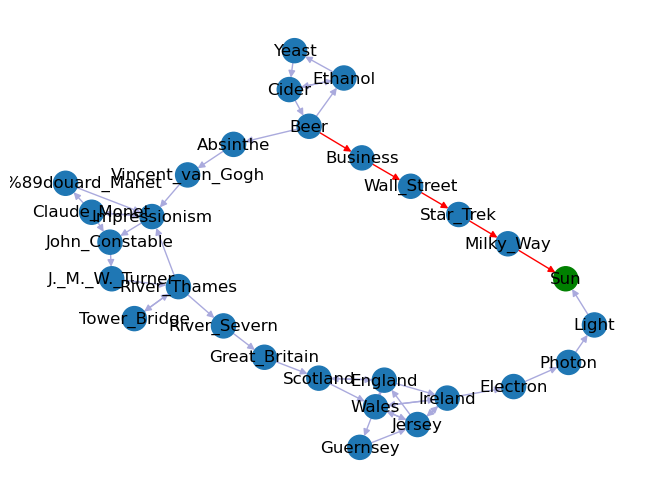

In [98]:
compare_paths_LLMs('Beer', 'Sun', 1)

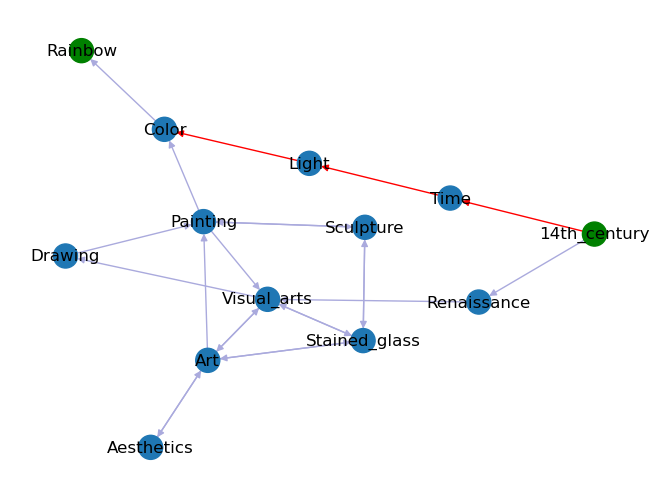

In [97]:
compare_paths_LLMs('14th_century', 'Rainbow', 1)
# llm2024.path.apply(remove_consecutive_duplicates).loc['14th_century', 'Rainbow']

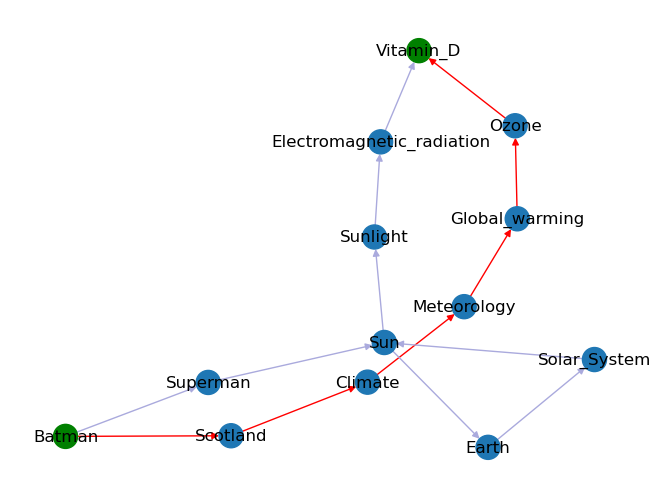

In [94]:
compare_paths_LLMs('Batman', 'Vitamin_D', 1)

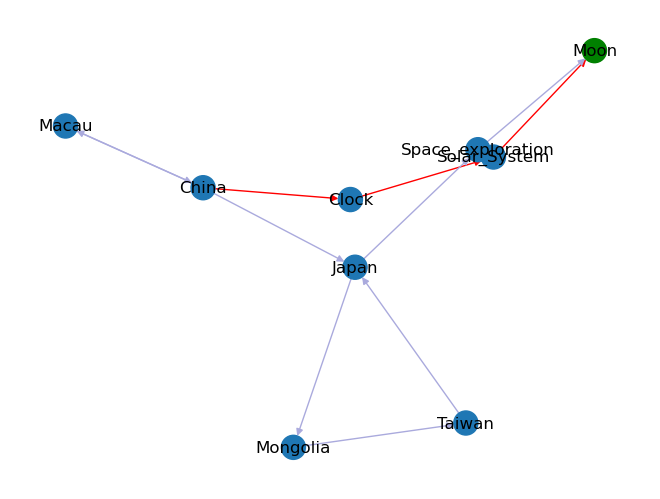

In [95]:
compare_paths_LLMs('China', 'Moon', 1)

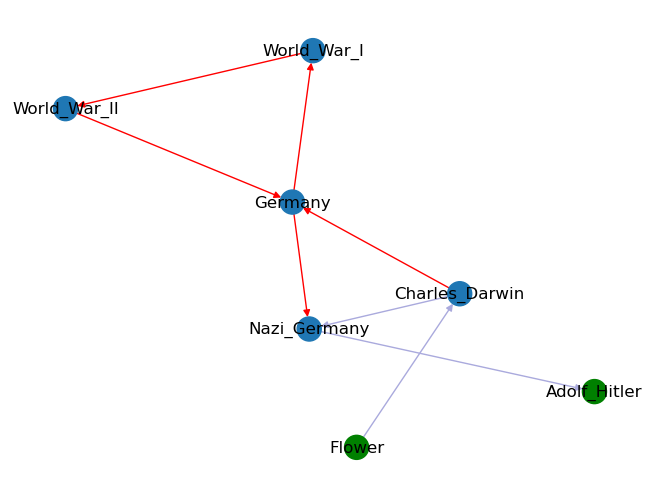

In [96]:
compare_paths_LLMs('Flower', 'Adolf_Hitler', 1)